In [1]:
# Importation des bibliothèques 
import geopandas as gpd
import rasterstats
import pandas as pd
from rasterstats import zonal_stats
import os 
from osgeo import gdal
import numpy as np
from collections import defaultdict
from my_function import apply_decision_rules, compute_confusion_matrix_with_plots

In [2]:
# Définition des cheminss d'accès 
my_folder = '/home/onyxia/work/Depot_Git/results/data'
sample_filename = os.path.join(my_folder, 'sample/Sample_BD_foret_T31TCJ.shp')
image_filename = os.path.join (my_folder,'classif/carte_essences_echelle_pixel.tif')

In [3]:
# Utilisation de zonal_stats pour obtenir le total des pixels par polygone
zonal_statistics = zonal_stats(
    sample_filename,
    image_filename,
    stats=["count"],  # Nombre total de pixels par polygone
    categorical=True  # Activer le mode catégoriel pour extraire les classes
)

# Chargement de raster pour extraire les classes
raster = gdal.Open(image_filename)
band = raster.GetRasterBand(1)  
raster_data = band.ReadAsArray()

# Boucle pour extraire les classes par polygone
# liste de dictionnaires pour stocker les pourcentages des classes par polygone
polygon_classes_percentages = []

# Parcourir les statistiques zonales
for idx, stats in enumerate(zonal_statistics):
    polygon_id = idx + 1  
    total_pixels = stats["count"]  # Nombre total de pixels dans le polygone

    # Initialisation d'un dictionnaire pour stocker les pourcentages des classes pour ce polygone
    class_percentages = {}
    
    # Parcourir chaque classe dans le polygone
    for class_value, pixel_count in stats.items():
        if class_value == "count":  # Ignorer le total
            continue
        
        # Calcul du pourcentage
        percentage = (pixel_count / total_pixels) * 100
        class_percentages[class_value] = percentage

    #  Ajout de résultats pour ce polygone
    polygon_classes_percentages.append({
        "polygon_id": polygon_id,
        "class_percentages": class_percentages
    })

# Affichage des résultats
for polygon_result in polygon_classes_percentages:
    print(f"Polygone {polygon_result['polygon_id']} :")
    for class_value, percentage in polygon_result["class_percentages"].items():
        print(f"  Classe {class_value}: {percentage:.2f}%")
        
# Transformation de resulats sous forme d'un dataframe pour qu'elle soit utilisée par la suite dans la fonction d'arbre de décision 
df_polygon_classes_percentages= pd.DataFrame(polygon_classes_percentages)
df_polygon_classes_percentages.head(5)

/opt/conda/lib/python3.12/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Polygone 1 :
Polygone 2 :
  Classe 12: 100.00%
Polygone 3 :
  Classe 12: 99.88%
  Classe 13: 0.06%
  Classe 14: 0.06%
Polygone 4 :
  Classe 12: 100.00%
Polygone 5 :
  Classe 12: 100.00%
Polygone 6 :
  Classe 12: 100.00%
Polygone 7 :
  Classe 11: 6.53%
  Classe 12: 93.32%
  Classe 14: 0.15%
Polygone 8 :
  Classe 12: 100.00%
Polygone 9 :
  Classe 11: 1.74%
  Classe 12: 97.30%
  Classe 23: 0.39%
  Classe 24: 0.58%
Polygone 10 :
  Classe 12: 100.00%
Polygone 11 :
  Classe 12: 100.00%
Polygone 12 :
  Classe 12: 100.00%
Polygone 13 :
  Classe 12: 100.00%
Polygone 14 :
  Classe 12: 100.00%
Polygone 15 :
  Classe 12: 94.69%
  Classe 14: 5.31%
Polygone 16 :
  Classe 12: 100.00%
Polygone 17 :
  Classe 12: 100.00%
Polygone 18 :
  Classe 12: 100.00%
Polygone 19 :
  Classe 12: 100.00%
Polygone 20 :
  Classe 12: 100.00%
Polygone 21 :
  Classe 12: 100.00%
Polygone 22 :
  Classe 12: 100.00%
Polygone 23 :
  Classe 12: 100.00%
Polygone 24 :
  Classe 12: 100.00%
Polygone 25 :
  Classe 12: 100.00%
Polygon

,polygon_id,class_percentages
0,1,{}
1,2,{12: 100.0}
2,3,"{12: 99.88459319099827, 13: 0.0577034045008655..."
3,4,{12: 100.0}
4,5,{12: 100.0}


In [4]:
import pandas as pd
import geopandas as gpd

def calculate_surface(samples_path, index):
    """
    Calcular la superficie de un polígono a partir de las muestras.

    Argumentos:
    - samples_path: Ruta al archivo de muestras.
    - index: Índice del polígono para el que se quiere calcular la superficie.

    Retorna:
    - La superficie del polígono en el índice dado.
    """
    samples = gpd.read_file(samples_path)
    if index in samples.index:
        return samples.loc[index, "geometry"].area
    else:
        return 0

def get_dominant_class(class_dict):
    """
    Identificar la clase dominante y su porcentaje a partir del diccionario de porcentajes.

    Argumentos:
    - class_dict: Diccionario que contiene las clases (códigos numéricos) y sus porcentajes.

    Retorna:
    - El código de la clase dominante y su porcentaje.
    """
    if class_dict:
        dominant_class_code = max(class_dict, key=class_dict.get)
        dominant_class_percentage = class_dict[dominant_class_code]
        return dominant_class_code, dominant_class_percentage
    else:
        return None, 0

def calculate_proportions(class_percentages):
    """
    Calcular la suma de las proporciones de feuillus y de conifères a partir de los datos de una fila.

    Argumentos:
    - class_percentages: Diccionario que contiene los porcentajes de diferentes clases.

    Retorna:
    - La suma de feuillus y conifères.
    """
    feuillus_classes = [11, 12, 13, 14, 15, 16]  # Ejemplo de clases que podrían ser de feuillus
    coniferes_classes = [21, 22, 23, 24, 25, 26, 27]  # Ejemplo de clases que podrían ser de conifères
    
    sum_feuillus = 0
    sum_coniferes = 0
    
    for class_value, percentage in class_percentages.items():
        if class_value in feuillus_classes:
            sum_feuillus += percentage
        elif class_value in coniferes_classes:
            sum_coniferes += percentage
    
    return sum_feuillus, sum_coniferes

def make_decision(surface, sum_feuillus, sum_coniferes, dominant_class_percentage, dominant_class_code):
    """
    Aplicar las reglas de decisión basadas en la superficie y las proporciones.

    Argumentos:
    - surface: La superficie del polígono.
    - sum_feuillus: La suma de las proporciones de feuillus.
    - sum_coniferes: La suma de las proporciones de conifères.
    - dominant_class_percentage: El porcentaje de la clase dominante.
    - dominant_class_code: El código de la clase dominante.

    Retorna:
    - El código predicho para este polígono.
    """
    if surface < 20000:  # Caso superficie < 2 ha
        if sum_feuillus > 75: 
            return 16
        elif sum_coniferes > 75: 
            return 27
        elif sum_coniferes > sum_feuillus: 
            return 28
        else:
            return 29
    else:  # Caso superficie >= 2 ha
        if dominant_class_percentage > 75:
            return int(dominant_class_code)  # Asegurar que sea un número entero
        elif sum_feuillus > 75: 
            return 15
        elif sum_coniferes > 75: 
            return 26
        elif sum_coniferes > sum_feuillus:
            return 28
        else:
            return 29

In [5]:
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

def apply_decision_rules(df_polygon_classes_percentages, sample_filename):
    """
    Aplicar las reglas de decisión para clasificar cada polígono en función de las proporciones de feuillus y conifères.
    """
    
    polygons = gpd.read_file(sample_filename)
    
    if not df_polygon_classes_percentages.index.equals(polygons.index):
        raise ValueError("Los índices del DataFrame de porcentajes de clases no coinciden con los índices del shapefile.")
    
    predictions = []
    
    for idx, row in df_polygon_classes_percentages.iterrows():
        logging.info(f"Processing polygon index: {idx}")
        class_percentages = row['class_percentages']
        
        sum_feuillus, sum_coniferes = calculate_proportions(class_percentages)
        surface = calculate_surface(sample_filename, idx)
        dominant_class_code, dominant_class_percentage = get_dominant_class(class_percentages)
        
        predicted_class = make_decision(surface, sum_feuillus, sum_coniferes, dominant_class_percentage, dominant_class_code)
        
        predictions.append(predicted_class)
    
    return pd.Series(predictions, index=polygons.index)

In [6]:
# # Asegúrate de ajustar la ruta del archivo shapefile
sample_filename = "/home/onyxia/work/Depot_Git/results/data/sample/Sample_BD_foret_T31TCJ.shp"  # Reemplázalo con la ruta real
predictions = apply_decision_rules(df_polygon_classes_percentages, sample_filename)

# # Mostrar las predicciones
print(predictions.head())

2025-01-28 15:19:10,791 Processing polygon index: 0
2025-01-28 15:19:11,053 Processing polygon index: 1
2025-01-28 15:19:11,289 Processing polygon index: 2
2025-01-28 15:19:11,523 Processing polygon index: 3
2025-01-28 15:19:11,755 Processing polygon index: 4
2025-01-28 15:19:11,987 Processing polygon index: 5
2025-01-28 15:19:12,224 Processing polygon index: 6
2025-01-28 15:19:12,464 Processing polygon index: 7
2025-01-28 15:19:12,833 Processing polygon index: 8
2025-01-28 15:19:13,064 Processing polygon index: 9
2025-01-28 15:19:13,276 Processing polygon index: 10
2025-01-28 15:19:13,487 Processing polygon index: 11
2025-01-28 15:19:13,698 Processing polygon index: 12
2025-01-28 15:19:13,924 Processing polygon index: 13
2025-01-28 15:19:14,166 Processing polygon index: 14
2025-01-28 15:19:14,405 Processing polygon index: 15
2025-01-28 15:19:14,643 Processing polygon index: 16
2025-01-28 15:19:14,883 Processing polygon index: 17
2025-01-28 15:19:15,117 Processing polygon index: 18
202

0    29
1    16
2    12
3    16
4    12
dtype: int64


In [7]:
print(predictions.unique())

[29 16 12 11 14 22 24 28 23 15 27 26 13 25 21]


In [8]:
import os
import geopandas as gpd

# Suponiendo que ya tienes cargado sample_filename y predictions
polygons = gpd.read_file(sample_filename)

# Añadir las predicciones al GeoDataFrame original
polygons["code_predit"] = predictions

# Guardar el archivo con las nuevas predicciones
output_path_samples = os.path.join(my_folder, "classif/carte_essences_echelle_peuplement2.shp")
polygons.to_file(output_path_samples)

/tmp/ipykernel_94508/1471625085.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  polygons.to_file(output_path_samples)
/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'code_predit' to 'code_predi'
  ogr_write(
2025-01-28 15:51:29,195 Created 11,050 records


   Code  code_predit
0    16           29
1    16           16
2    15           12
3    16           16
4    15           12
5    15           12
6    28           12
7    12           12
8    29           12
9    12           12


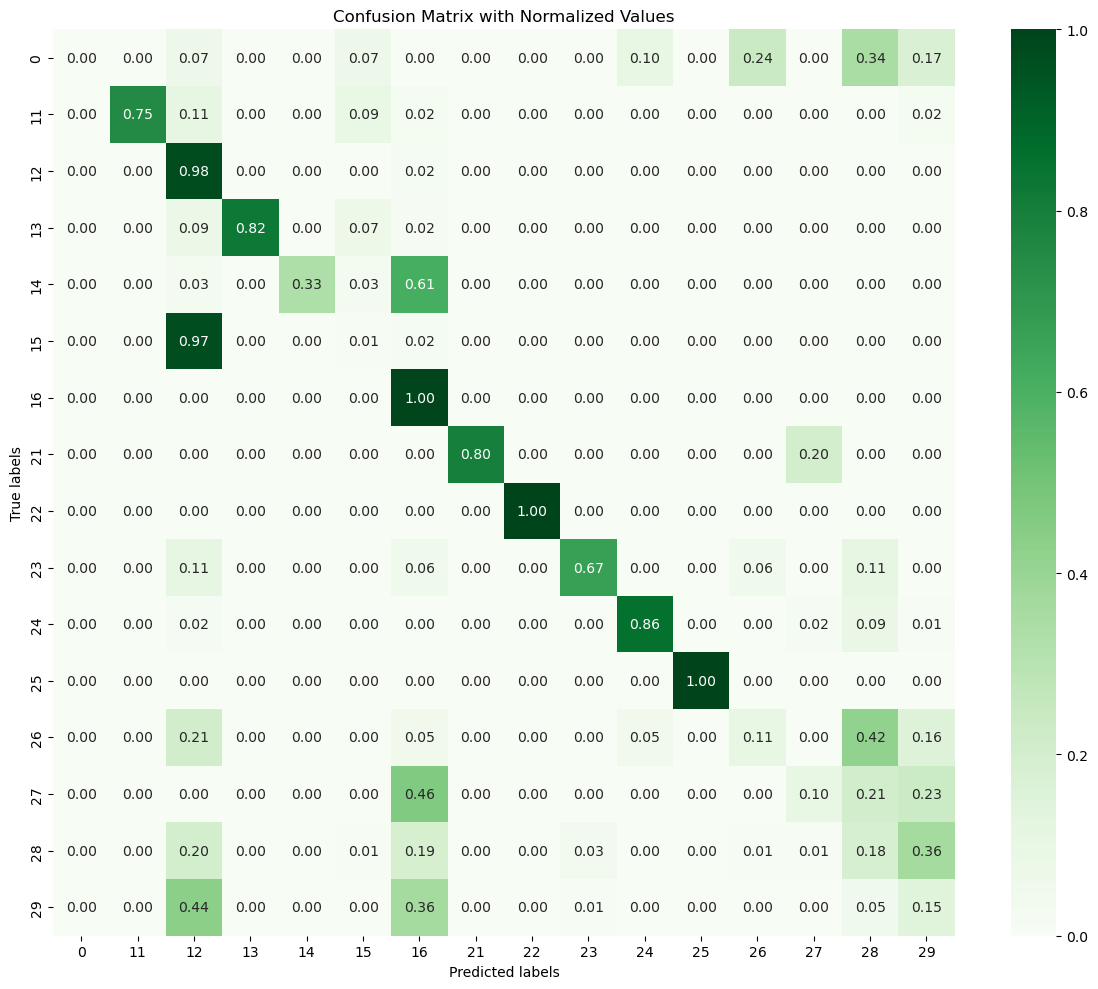

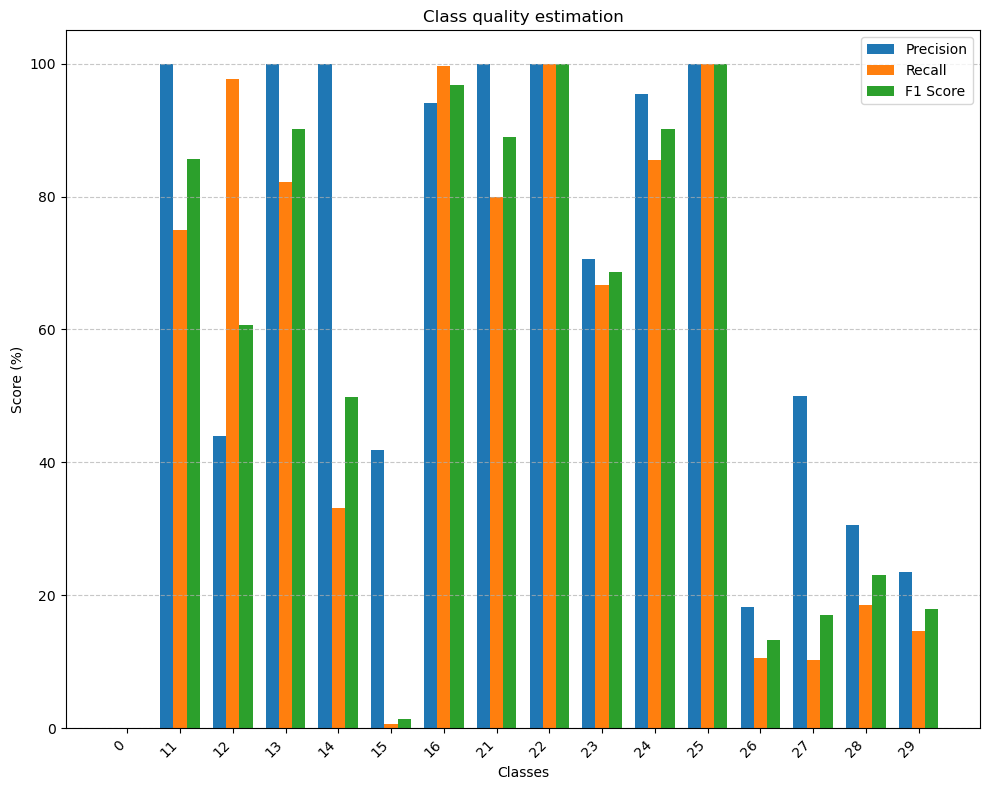

{'confusion_matrix': array([[   0,    0,    2,    0,    0,    2,    0,    0,    0,    0,    3,
           0,    7,    0,   10,    5],
       [   0,   96,   14,    0,    0,   12,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    3],
       [   0,    0, 2121,    0,    0,    1,   48,    0,    0,    0,    0,
           0,    0,    0,    0,    2],
       [   0,    0,    5,   46,    0,    4,    1,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   0,    0,    5,    0,   57,    5,  105,    0,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   0,    0, 2556,    0,    0,   18,   58,    0,    0,    0,    0,
           0,    0,    0,    0,    9],
       [   0,    0,    0,    0,    0,    0, 5303,    0,    0,    0,    0,
           0,    0,    0,    3,   19],
       [   0,    0,    0,    0,    0,    0,    0,    4,    0,    0,    0,
           0,    0,    1,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    8,    0,    0,
 

In [10]:
# Calcul de  la matrice de confusion
confusion_matrix = compute_confusion_matrix_with_plots(polygons,"Code","code_predit")
print(confusion_matrix)